In [1]:
%matplotlib inline
from matplotlib import rc
from matplotlib import pyplot as plt
plt.rcParams['axes.unicode_minus'] = False

rc('font', family='Malgun Gothic')  # Windows 일 경우
# rc('font', family='AppleGothic')  # Mac 일 경우

import numpy as np
import pandas as pd

## 1/01_bigdata_python_for_student.ipynb

실습: Naver 쇼핑 크롤러 (Crawler)

+ https://shopping.naver.com/ 에서 인기있는 세탁기 모델 찾기

## 1/02_python_basic_for_student.ipynb

### 주식 데이터

In [2]:
import pandas_datareader as pdr

lge_df = pdr.get_data_yahoo('066570.KS', '2018-04-01')
print(lge_df.shape)
lge_df.head()

(152, 6)


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-04-02,112500,110000,110000,110500,340315,110500
2018-04-03,112000,109000,109500,110500,377188,110500
2018-04-04,111000,104500,110500,104500,909945,104500
2018-04-05,107500,104500,106000,105000,644490,105000
2018-04-06,111500,105000,105500,111000,1519548,111000


In [3]:
lge_df['Volume'].head()

Date
2018-04-02     340315
2018-04-03     377188
2018-04-04     909945
2018-04-05     644490
2018-04-06    1519548
Name: Volume, dtype: int64

In [4]:
lge_df['Volume'].diff().head()

Date
2018-04-02         NaN
2018-04-03     36873.0
2018-04-04    532757.0
2018-04-05   -265455.0
2018-04-06    875058.0
Name: Volume, dtype: float64

In [5]:
lge_df['Volume_diff'] = lge_df['Volume'].diff()
lge_df['Volume_diff_percent'] = 100 * lge_df['Volume_diff'] / lge_df['Volume']
lge_df.head()

,High,Low,Open,Close,Volume,Adj Close,Volume_diff,Volume_diff_percent
Date,,,,,,,,
2018-04-02,112500,110000,110000,110500,340315,110500,NaN,NaN
2018-04-03,112000,109000,109500,110500,377188,110500,36873.0,9.775762
2018-04-04,111000,104500,110500,104500,909945,104500,532757.0,58.548264
2018-04-05,107500,104500,106000,105000,644490,105000,-265455.0,-41.188382
2018-04-06,111500,105000,105500,111000,1519548,111000,875058.0,57.586730


In [6]:
# 소수점 2자리로 정리
lge_df['Volume_diff_percent'] = np.round(lge_df['Volume_diff_percent'], 2)
lge_df.tail()

,High,Low,Open,Close,Volume,Adj Close,Volume_diff,Volume_diff_percent
Date,,,,,,,,
2018-11-08,70700,68300,68800,69900,1080894,69900,342024.0,31.64
2018-11-09,72300,69700,70000,71400,1129981,71400,49087.0,4.34
2018-11-12,72200,70000,71000,71200,631830,71200,-498151.0,-78.84
2018-11-13,71400,68800,70200,70200,680494,70200,48664.0,7.15
2018-11-14,71000,68700,69600,69500,527813,69500,-152681.0,-28.93


<div class="alert alert-info">
지금까지 Feature Engineering 작업을 했습니다.
    
유의미하게 생각되는 데이터를 있는 데이터 안에서 새롭게 만들어내는 방법
</div>

In [7]:
def to_label(percent):
    if percent >= 40:
        return 'Over'
    return ''

lge_df['Volume_diff_label'] = lge_df['Volume_diff_percent'].apply(to_label)
lge_df.head()

,High,Low,Open,Close,Volume,Adj Close,Volume_diff,Volume_diff_percent,Volume_diff_label
Date,,,,,,,,,
2018-04-02,112500,110000,110000,110500,340315,110500,NaN,NaN,
2018-04-03,112000,109000,109500,110500,377188,110500,36873.0,9.78,
2018-04-04,111000,104500,110500,104500,909945,104500,532757.0,58.55,Over
2018-04-05,107500,104500,106000,105000,644490,105000,-265455.0,-41.19,
2018-04-06,111500,105000,105500,111000,1519548,111000,875058.0,57.59,Over


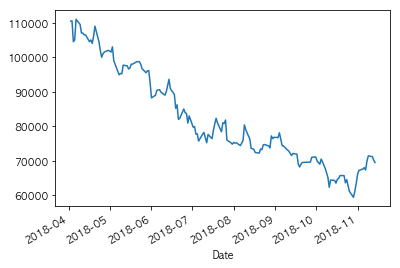

In [8]:
lge_df['Adj Close'].plot()

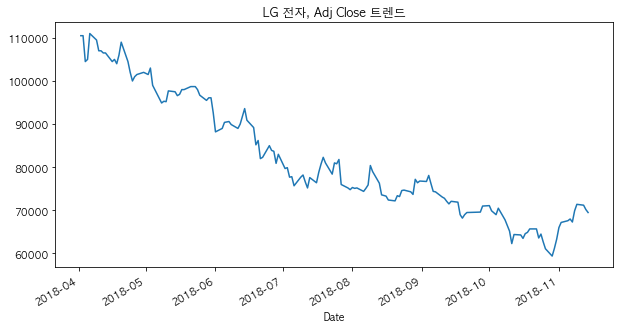

In [9]:
lge_df['Adj Close'].plot(title='LG 전자, Adj Close 트렌드', figsize=(10, 5))

### 공공 데이터

[공공데이터 포털](https://www.data.go.kr)내 [대기오염정보 조회 서비스](https://www.data.go.kr/dataset/15000581/openapi.do?mypageFlag=Y) 중에서

+ No 4. 대기질 예보통보 조회 : 통보코드와 통보시간으로 예보정보와 발생 원인 정보를 조회하는 대기질(미세먼지/오존) 예보통보 조회
    - numOfRows : 한 페이지 결과 수 (조회 날짜로 검색 시 사용 안함)
    - pageNo : 페이지 번호(조회 날짜로 검색 시 사용 안함)
    - searchDate : 통보시간 검색 (조회 날짜 입력 없을 경우 한달동안 예보통보 발령 날짜의 리스트 정보를 확인)
    - InformCode : 통보코드검색 (PM10 : 미세먼지 PM25 : 초미세먼지 O3 : 오존)

In [10]:
import datetime
import requests
from urllib.parse import unquote

In [11]:
# 위 API 페이지에서 신청 가능 => 발급 후, 1시간 후에 사용 가능

# 아래는 강사의 인증키 => base64 인코딩의 문자열인데, 모양이 ???
인증키 = "19Vd8w1VF6MhraamtQDCGukzgHbTbDksZvFa3yYHrfdvdsmlCZ9TnKwG9DkHkLabLTxYBw3vgymDd4MR7bg9%2Bg%3D%3D"

In [12]:
인증키 = unquote(인증키)
인증키

'19Vd8w1VF6MhraamtQDCGukzgHbTbDksZvFa3yYHrfdvdsmlCZ9TnKwG9DkHkLabLTxYBw3vgymDd4MR7bg9+g=='

In [13]:
api_endpoint = 'http://openapi.airkorea.or.kr/openapi/services/rest/ArpltnInforInqireSvc/getMinuDustFrcstDspth'

# today = datetime.datetime.now().strftime('%Y-%m-%d')
today = '2018-11-14',

params = {
    'searchDate': today,
    'ServiceKey': 인증키,
    '_returnType': 'json',
}

In [14]:
res = requests.get(api_endpoint, params=params)
res.text

'{"MinuDustFrcstDspthVo":{"_returnType":"json","actionKnack":"","dataTime":"","f_data_time":"","f_data_time1":"","f_data_time2":"","f_data_time3":"","f_inform_data":"","imageUrl1":"","imageUrl2":"","imageUrl3":"","imageUrl4":"","imageUrl5":"","imageUrl6":"","imageUrl7":"","imageUrl8":"","imageUrl9":"","informCause":"","informCode":"","informData":"","informGrade":"","informOverall":"","numOfRows":"10","pageNo":"1","resultCode":"","resultMsg":"","searchDate":"2018-11-14","serviceKey":"19Vd8w1VF6MhraamtQDCGukzgHbTbDksZvFa3yYHrfdvdsmlCZ9TnKwG9DkHkLabLTxYBw3vgymDd4MR7bg9+g==","totalCount":"","ver":""},"list":[{"_returnType":"json","actionKnack":"","dataTime":"2018-11-14 23시 발표","f_data_time":"2018111423","f_data_time1":"20181114","f_data_time2":"20181115","f_data_time3":"20181116","f_inform_data":"20181114","imageUrl1":"http://www.airkorea.or.kr/file/viewImage/?atch_id=99557","imageUrl2":"http://www.airkorea.or.kr/file/viewImage/?atch_id=99558","imageUrl3":"http://www.airkorea.or.kr/file/v

In [15]:
# import json
# json_obj = json.loads(res.text)

json_obj = res.json()
json_obj

{'MinuDustFrcstDspthVo': {'_returnType': 'json',
  'actionKnack': '',
  'dataTime': '',
  'f_data_time': '',
  'f_data_time1': '',
  'f_data_time2': '',
  'f_data_time3': '',
  'f_inform_data': '',
  'imageUrl1': '',
  'imageUrl2': '',
  'imageUrl3': '',
  'imageUrl4': '',
  'imageUrl5': '',
  'imageUrl6': '',
  'imageUrl7': '',
  'imageUrl8': '',
  'imageUrl9': '',
  'informCause': '',
  'informCode': '',
  'informData': '',
  'informGrade': '',
  'informOverall': '',
  'numOfRows': '10',
  'pageNo': '1',
  'resultCode': '',
  'resultMsg': '',
  'searchDate': '2018-11-14',
  'serviceKey': '19Vd8w1VF6MhraamtQDCGukzgHbTbDksZvFa3yYHrfdvdsmlCZ9TnKwG9DkHkLabLTxYBw3vgymDd4MR7bg9+g==',
  'totalCount': '',
  'ver': ''},
 'list': [{'_returnType': 'json',
   'actionKnack': '',
   'dataTime': '2018-11-14 23시 발표',
   'f_data_time': '2018111423',
   'f_data_time1': '20181114',
   'f_data_time2': '20181115',
   'f_data_time3': '20181116',
   'f_inform_data': '20181114',
   'imageUrl1': 'http://www.

In [16]:
json_obj['list']

[{'_returnType': 'json',
  'actionKnack': '',
  'dataTime': '2018-11-14 23시 발표',
  'f_data_time': '2018111423',
  'f_data_time1': '20181114',
  'f_data_time2': '20181115',
  'f_data_time3': '20181116',
  'f_inform_data': '20181114',
  'imageUrl1': 'http://www.airkorea.or.kr/file/viewImage/?atch_id=99557',
  'imageUrl2': 'http://www.airkorea.or.kr/file/viewImage/?atch_id=99558',
  'imageUrl3': 'http://www.airkorea.or.kr/file/viewImage/?atch_id=99559',
  'imageUrl4': 'http://www.airkorea.or.kr/file/viewImage/?atch_id=99560',
  'imageUrl5': 'http://www.airkorea.or.kr/file/viewImage/?atch_id=99561',
  'imageUrl6': 'http://www.airkorea.or.kr/file/viewImage/?atch_id=99562',
  'imageUrl7': 'http://www.airkorea.or.kr/file/viewImage/?atch_id=99553',
  'imageUrl8': 'http://www.airkorea.or.kr/file/viewImage/?atch_id=',
  'imageUrl9': 'http://www.airkorea.or.kr/file/viewImage/?atch_id=',
  'informCause': "○ [미세먼지] 대부분 '보통' 수준이겠으나, 일부 서쪽 지역은 대기 정체로 국내 생성 미세먼지가 축적되어 농도가 높을 것으로 예상됨.",
  'informCode':

In [17]:
먼지_df = pd.DataFrame(json_obj['list'])
print(먼지_df.shape)
먼지_df.head()

(20, 30)


,_returnType,actionKnack,dataTime,f_data_time,f_data_time1,f_data_time2,f_data_time3,f_inform_data,imageUrl1,imageUrl2,...,informGrade,informOverall,numOfRows,pageNo,resultCode,resultMsg,searchDate,serviceKey,totalCount,ver
0,json,,2018-11-14 23시 발표,2018111423,20181114,20181115,20181116,20181114,http://www.airkorea.or.kr/file/viewImage/?atch...,http://www.airkorea.or.kr/file/viewImage/?atch...,...,"서울 : 보통,제주 : 좋음,전남 : 보통,전북 : 보통,광주 : 보통,경남 : 좋...","○ [미세먼지] 광주·전북은 '나쁨', 그 밖의 권역은 '좋음'∼'보통'으로 예상됨.",10,1,,,,,,
1,json,,2018-11-14 23시 발표,2018111423,20181114,20181115,20181116,20181115,http://www.airkorea.or.kr/file/viewImage/?atch...,http://www.airkorea.or.kr/file/viewImage/?atch...,...,"서울 : 보통,제주 : 좋음,전남 : 보통,전북 : 보통,광주 : 보통,경남 : 보...","○ [미세먼지] 수도권·충남·광주·전북은 '나쁨', 그 밖의 권역은 '좋음'∼'보통...",10,1,,,,,,
2,json,,2018-11-14 23시 발표,2018111423,20181114,20181115,20181116,20181116,http://www.airkorea.or.kr/file/viewImage/?atch...,http://www.airkorea.or.kr/file/viewImage/?atch...,...,"서울 : 보통,제주 : 좋음,전남 : 보통,전북 : 보통,광주 : 보통,경남 : 보...","○ [미세먼지] 수도권·강원권·충청권·광주·전북·대구·경북은 '나쁨', 그 밖의 권...",10,1,,,,,,
3,json,,2018-11-14 23시 발표,2018111423,20181114,20181115,20181116,20181114,http://www.airkorea.or.kr/file/viewImage/?atch...,http://www.airkorea.or.kr/file/viewImage/?atch...,...,"서울 : 보통,제주 : 보통,전남 : 보통,전북 : 나쁨,광주 : 나쁨,경남 : 좋...","○ [미세먼지] 광주·전북은 '나쁨', 그 밖의 권역은 '좋음'∼'보통'으로 예상됨.",10,1,,,,,,
4,json,,2018-11-14 23시 발표,2018111423,20181114,20181115,20181116,20181115,http://www.airkorea.or.kr/file/viewImage/?atch...,http://www.airkorea.or.kr/file/viewImage/?atch...,...,"서울 : 나쁨,제주 : 좋음,전남 : 보통,전북 : 나쁨,광주 : 나쁨,경남 : 보...","○ [미세먼지] 수도권·충남·광주·전북은 '나쁨', 그 밖의 권역은 '좋음'∼'보통...",10,1,,,,,,


In [18]:
먼지_df.columns

Index(['_returnType', 'actionKnack', 'dataTime', 'f_data_time', 'f_data_time1',
       'f_data_time2', 'f_data_time3', 'f_inform_data', 'imageUrl1',
       'imageUrl2', 'imageUrl3', 'imageUrl4', 'imageUrl5', 'imageUrl6',
       'imageUrl7', 'imageUrl8', 'imageUrl9', 'informCause', 'informCode',
       'informData', 'informGrade', 'informOverall', 'numOfRows', 'pageNo',
       'resultCode', 'resultMsg', 'searchDate', 'serviceKey', 'totalCount',
       'ver'],
      dtype='object')

In [19]:
names = ['dataTime', 'informCause', 'informCode', 'informData', 'informGrade', 'informOverall']
먼지_df = 먼지_df[names]
먼지_df.head()

,dataTime,informCause,informCode,informData,informGrade,informOverall
0,2018-11-14 23시 발표,"○ [미세먼지] 대부분 '보통' 수준이겠으나, 일부 서쪽 지역은 대기 정체로 국내 ...",PM10,2018-11-14,"서울 : 보통,제주 : 좋음,전남 : 보통,전북 : 보통,광주 : 보통,경남 : 좋...","○ [미세먼지] 광주·전북은 '나쁨', 그 밖의 권역은 '좋음'∼'보통'으로 예상됨."
1,2018-11-14 23시 발표,"○ [미세먼지] 대부분 '보통' 수준이겠으나, 서쪽지역은 대기 정체로 국내 생성 미...",PM10,2018-11-15,"서울 : 보통,제주 : 좋음,전남 : 보통,전북 : 보통,광주 : 보통,경남 : 보...","○ [미세먼지] 수도권·충남·광주·전북은 '나쁨', 그 밖의 권역은 '좋음'∼'보통..."
2,2018-11-14 23시 발표,○ [미세먼지] 대부분 지역은 대기 정체로 축적된 국내 생성 미세먼지에 국외에서 유...,PM10,2018-11-16,"서울 : 보통,제주 : 좋음,전남 : 보통,전북 : 보통,광주 : 보통,경남 : 보...","○ [미세먼지] 수도권·강원권·충청권·광주·전북·대구·경북은 '나쁨', 그 밖의 권..."
3,2018-11-14 23시 발표,"○ [미세먼지] 대부분 '보통' 수준이겠으나, 일부 서쪽 지역은 대기 정체로 국내 ...",PM25,2018-11-14,"서울 : 보통,제주 : 보통,전남 : 보통,전북 : 나쁨,광주 : 나쁨,경남 : 좋...","○ [미세먼지] 광주·전북은 '나쁨', 그 밖의 권역은 '좋음'∼'보통'으로 예상됨."
4,2018-11-14 23시 발표,"○ [미세먼지] 대부분 '보통' 수준이겠으나, 서쪽지역은 대기 정체로 국내 생성 미...",PM25,2018-11-15,"서울 : 나쁨,제주 : 좋음,전남 : 보통,전북 : 나쁨,광주 : 나쁨,경남 : 보...","○ [미세먼지] 수도권·충남·광주·전북은 '나쁨', 그 밖의 권역은 '좋음'∼'보통..."


In [20]:
# TODO: informGrade 필드를 Feature Engineering 해봅시다.
먼지_df['informGrade'][0]

'서울 : 보통,제주 : 좋음,전남 : 보통,전북 : 보통,광주 : 보통,경남 : 좋음,경북 : 좋음,울산 : 좋음,대구 : 좋음,부산 : 좋음,충남 : 보통,충북 : 보통,세종 : 보통,대전 : 보통,영동 : 좋음,영서 : 보통,경기남부 : 보통,경기북부 : 보통,인천 : 보통'

In [21]:
inform_grade = 먼지_df['informGrade'][0]

지역_리스트 = [word.split(':')[0].strip() for word in inform_grade.split(',')]
상태_리스트 = [word.split(':')[1].strip() for word in inform_grade.split(',')]

print(지역_리스트)
print(상태_리스트)

['서울', '제주', '전남', '전북', '광주', '경남', '경북', '울산', '대구', '부산', '충남', '충북', '세종', '대전', '영동', '영서', '경기남부', '경기북부', '인천']
['보통', '좋음', '보통', '보통', '보통', '좋음', '좋음', '좋음', '좋음', '좋음', '보통', '보통', '보통', '보통', '좋음', '보통', '보통', '보통', '보통']


In [22]:
def convert_inform_grade(inform_grade):
    상태_리스트 = [word.split(':')[1].strip() for word in inform_grade.split(',')]
    return pd.Series(상태_리스트)
    
inform_grade_df = 먼지_df['informGrade'].apply(convert_inform_grade)
inform_grade_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,보통,좋음,보통,보통,보통,좋음,좋음,좋음,좋음,좋음,보통,보통,보통,보통,좋음,보통,보통,보통,보통
1,보통,좋음,보통,보통,보통,보통,보통,보통,보통,보통,보통,보통,보통,보통,좋음,보통,보통,보통,보통
2,보통,좋음,보통,보통,보통,보통,보통,보통,보통,보통,나쁨,보통,보통,보통,보통,보통,나쁨,보통,보통
3,보통,보통,보통,나쁨,나쁨,좋음,보통,좋음,좋음,좋음,보통,보통,보통,보통,좋음,보통,보통,보통,보통
4,나쁨,좋음,보통,나쁨,나쁨,보통,보통,보통,보통,보통,나쁨,보통,보통,보통,좋음,보통,나쁨,나쁨,나쁨


In [23]:
inform_grade_df.columns = 지역_리스트
inform_grade_df.head()

,서울,제주,전남,전북,광주,경남,경북,울산,대구,부산,충남,충북,세종,대전,영동,영서,경기남부,경기북부,인천
0,보통,좋음,보통,보통,보통,좋음,좋음,좋음,좋음,좋음,보통,보통,보통,보통,좋음,보통,보통,보통,보통
1,보통,좋음,보통,보통,보통,보통,보통,보통,보통,보통,보통,보통,보통,보통,좋음,보통,보통,보통,보통
2,보통,좋음,보통,보통,보통,보통,보통,보통,보통,보통,나쁨,보통,보통,보통,보통,보통,나쁨,보통,보통
3,보통,보통,보통,나쁨,나쁨,좋음,보통,좋음,좋음,좋음,보통,보통,보통,보통,좋음,보통,보통,보통,보통
4,나쁨,좋음,보통,나쁨,나쁨,보통,보통,보통,보통,보통,나쁨,보통,보통,보통,좋음,보통,나쁨,나쁨,나쁨


In [24]:
먼지_df = pd.concat([먼지_df, inform_grade_df], axis="columns")
먼지_df.head()

,dataTime,informCause,informCode,informData,informGrade,informOverall,서울,제주,전남,전북,...,부산,충남,충북,세종,대전,영동,영서,경기남부,경기북부,인천
0,2018-11-14 23시 발표,"○ [미세먼지] 대부분 '보통' 수준이겠으나, 일부 서쪽 지역은 대기 정체로 국내 ...",PM10,2018-11-14,"서울 : 보통,제주 : 좋음,전남 : 보통,전북 : 보통,광주 : 보통,경남 : 좋...","○ [미세먼지] 광주·전북은 '나쁨', 그 밖의 권역은 '좋음'∼'보통'으로 예상됨.",보통,좋음,보통,보통,...,좋음,보통,보통,보통,보통,좋음,보통,보통,보통,보통
1,2018-11-14 23시 발표,"○ [미세먼지] 대부분 '보통' 수준이겠으나, 서쪽지역은 대기 정체로 국내 생성 미...",PM10,2018-11-15,"서울 : 보통,제주 : 좋음,전남 : 보통,전북 : 보통,광주 : 보통,경남 : 보...","○ [미세먼지] 수도권·충남·광주·전북은 '나쁨', 그 밖의 권역은 '좋음'∼'보통...",보통,좋음,보통,보통,...,보통,보통,보통,보통,보통,좋음,보통,보통,보통,보통
2,2018-11-14 23시 발표,○ [미세먼지] 대부분 지역은 대기 정체로 축적된 국내 생성 미세먼지에 국외에서 유...,PM10,2018-11-16,"서울 : 보통,제주 : 좋음,전남 : 보통,전북 : 보통,광주 : 보통,경남 : 보...","○ [미세먼지] 수도권·강원권·충청권·광주·전북·대구·경북은 '나쁨', 그 밖의 권...",보통,좋음,보통,보통,...,보통,나쁨,보통,보통,보통,보통,보통,나쁨,보통,보통
3,2018-11-14 23시 발표,"○ [미세먼지] 대부분 '보통' 수준이겠으나, 일부 서쪽 지역은 대기 정체로 국내 ...",PM25,2018-11-14,"서울 : 보통,제주 : 보통,전남 : 보통,전북 : 나쁨,광주 : 나쁨,경남 : 좋...","○ [미세먼지] 광주·전북은 '나쁨', 그 밖의 권역은 '좋음'∼'보통'으로 예상됨.",보통,보통,보통,나쁨,...,좋음,보통,보통,보통,보통,좋음,보통,보통,보통,보통
4,2018-11-14 23시 발표,"○ [미세먼지] 대부분 '보통' 수준이겠으나, 서쪽지역은 대기 정체로 국내 생성 미...",PM25,2018-11-15,"서울 : 나쁨,제주 : 좋음,전남 : 보통,전북 : 나쁨,광주 : 나쁨,경남 : 보...","○ [미세먼지] 수도권·충남·광주·전북은 '나쁨', 그 밖의 권역은 '좋음'∼'보통...",나쁨,좋음,보통,나쁨,...,보통,나쁨,보통,보통,보통,좋음,보통,나쁨,나쁨,나쁨


## 2/01_numpy-pandas-matplotlib_taster_for_student.ipynb

+ 지도 학습 : 데이터에 답이 정해져있고 그것을 학습하는 것
    - classification (분류) : 주어진 데이터를 정해진 카테고리에 따라 분류하는 문제
    - regression (회귀분석) : 주어진 데이터가 어떤 함수로부터 생성됐는가를 알아보는 "함수 관계"를 추측
+ 비지도 학습 : 정해진 답은 없고 스스로 기준을 만들고 분류
    + clustering (군집화) : 아무런 정보가 없는 상태에서 데이터를 분류하는 방법 => 이미지 데이터 처리
+ dimensionality reduction (차원 축소)

## 2/02_LG_Washing_Machine_for_student.ipynb

### LG Washing Machine Dataset

목적: 세탁기에서 생성된 Log Data를 분석해보자

데이터 셋 정보 (Metadata)
+ washer.csv: 세탁기에서 생성된 Log 데이터
+ metadata.csv: washer.csv의 각 컬럼 내용에 대한 설명

#### 전처리

In [25]:
washer_df = pd.read_csv('LG_Python_Lecture_for_student_181010/2/data/washing_machine/washer.csv')
print(washer_df.shape)
washer_df.head()

(500, 32)


,category_code,model_name,regist_country,create_dt_utc,device_id,event_type,mon_data,State,Remain_Time_H,Remain_Time_M,...,ChildLock,Steam,RemoteStart,TurboShot,InitialBit,PreState,SmartCourse,TCLCount,OPCourse,LoadLevel
0,201,LG_WM_KR,KR,16/11/2017 0:22,A1,WM_STATE,KAALARsBAAADAAAAAAAABAABqB4/AhUB,40,0,11,...,0,0,0,0,0,30,63,2,21,1
1,201,LG_WM_KR,KR,16/11/2017 0:32,A1,WM_STATE,PAAAAAAAAAAAAAAAAAAABAABuSg/AxUA,60,0,0,...,0,0,0,0,0,40,63,3,21,0
2,201,LG_WM_KR,KR,16/11/2017 0:32,A1,WM_WASH_END,PAAAAAAAAAAAAAAAAAAABAABuSg/AxUA,60,0,0,...,0,0,0,0,0,40,63,3,21,0
3,201,LG_WM_KR,KR,16/11/2017 2:48,A1,COMMON_WIFI_ON,HgALAAsBAAAAAAEAAAAABAAAADw/AxUF,30,0,11,...,0,0,0,0,0,60,63,3,21,5
4,201,LG_WM_KR,KR,16/11/2017 2:57,A1,WM_STATE,PAAAAAAAAAAAAAAAAAAABAAAEB4/AxUA,60,0,0,...,0,0,0,0,0,30,63,3,21,0


In [26]:
washer_df.columns

Index(['category_code', 'model_name', 'regist_country', 'create_dt_utc',
       'device_id', 'event_type', 'mon_data', 'State', 'Remain_Time_H',
       'Remain_Time_M', 'Initial_Time_H', 'Initial_Time_M', 'APCourse',
       'Error', 'SoilLevel', 'SpinSpeed', 'WaterTemp', 'RinseCount',
       'DryLevel', 'Reserve_Time_H', 'Reserve_Time_M', 'FreshCare',
       'ChildLock', 'Steam', 'RemoteStart', 'TurboShot', 'InitialBit',
       'PreState', 'SmartCourse', 'TCLCount', 'OPCourse', 'LoadLevel'],
      dtype='object')

In [27]:
washer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 32 columns):
category_code     500 non-null int64
model_name        500 non-null object
regist_country    500 non-null object
create_dt_utc     500 non-null object
device_id         500 non-null object
event_type        500 non-null object
mon_data          500 non-null object
State             500 non-null int64
Remain_Time_H     500 non-null int64
Remain_Time_M     500 non-null int64
Initial_Time_H    500 non-null int64
Initial_Time_M    500 non-null int64
APCourse          500 non-null int64
Error             500 non-null int64
SoilLevel         500 non-null int64
SpinSpeed         500 non-null int64
WaterTemp         500 non-null int64
RinseCount        500 non-null int64
DryLevel          500 non-null int64
Reserve_Time_H    500 non-null int64
Reserve_Time_M    500 non-null int64
FreshCare         500 non-null int64
ChildLock         500 non-null int64
Steam             500 non-null int64
R

In [28]:
meta_df = pd.read_csv('LG_Python_Lecture_for_student_181010/2/data/washing_machine/metadata.csv')
print(meta_df.shape)
meta_df.head()

(32, 2)


,column_name,description
0,category_code,카테고리 코드
1,model_name,모델명
2,regist_country,등록국가명
3,create_dt_utc,세탁종료시간
4,device_id,세탁기 Device 구분을 위한 고유ID(decoded)


<div class="alert alert-info">
현재 데이터 만으로는 분석을 할만한 데이터가 많지는 않습니다.

+ 쓸만한 컬럼: create_dt_utc, device_id, event_type, APCourse
+ 삭제할 컬럼: category_code, model_name, regist_country, Error, Reserve_Time_H, Reserve_Time_M, FreshCare, Steam, RemoteStart, TurboShot, InitialBit
+ 그 외 컬럼: 판단하기 어려움, 무의미해 보임
</div>

In [29]:
names = ['create_dt_utc', 'device_id', 'event_type', 'APCourse']
washer_df[names]

,create_dt_utc,device_id,event_type,APCourse
0,16/11/2017 0:22,A1,WM_STATE,1
1,16/11/2017 0:32,A1,WM_STATE,0
2,16/11/2017 0:32,A1,WM_WASH_END,0
3,16/11/2017 2:48,A1,COMMON_WIFI_ON,1
4,16/11/2017 2:57,A1,WM_STATE,0
5,16/11/2017 2:57,A1,WM_WASH_END,0
6,16/11/2017 2:58,A1,WM_WASH_BEGIN,1
7,16/11/2017 2:58,A1,WM_STATE,1
8,16/11/2017 3:26,A1,WM_STATE,1
9,16/11/2017 3:57,A1,WM_STATE,0


#### Grouping

+ 지금까지 데이터를 새로 생성하고 필요없는 컬럼은 삭제하는 등의 전처리를 진행했습니다.
+ 이번에는 로그가 발생한 device id별 유형(event_type)이 어떤 것들이 있는지 살펴보겠습니다.

In [30]:
washer_df['event_type'].value_counts()

WM_STATE          294
COMMON_WIFI_ON     65
WM_WASH_END        64
WM_WASH_BEGIN      40
WM_PAUSE           23
WM_CONTINUE        11
WM_ERROR            3
Name: event_type, dtype: int64

In [31]:
# device_id별 event_type 갯수 ?

In [32]:
washer_df['device_id'].unique()

array(['A1', 'A2', 'A3', 'A4', 'A5'], dtype=object)

In [33]:
washer_df['event_type'].unique()

array(['WM_STATE', 'WM_WASH_END', 'COMMON_WIFI_ON', 'WM_WASH_BEGIN',
       'WM_PAUSE', 'WM_CONTINUE', 'WM_ERROR'], dtype=object)

In [34]:
# washer_df.groupby(['device_id', 'event_type']).size()
washer_df.groupby(['device_id', 'event_type']).agg('size')

device_id  event_type    
A1         COMMON_WIFI_ON    13
           WM_PAUSE           2
           WM_STATE          64
           WM_WASH_BEGIN     12
           WM_WASH_END       17
A2         COMMON_WIFI_ON    13
           WM_CONTINUE        2
           WM_PAUSE           7
           WM_STATE          60
           WM_WASH_BEGIN      2
           WM_WASH_END       12
A3         COMMON_WIFI_ON    11
           WM_CONTINUE        9
           WM_ERROR           2
           WM_PAUSE          12
           WM_STATE          51
           WM_WASH_BEGIN      8
           WM_WASH_END       11
A4         COMMON_WIFI_ON    16
           WM_STATE          62
           WM_WASH_BEGIN     10
           WM_WASH_END       12
A5         COMMON_WIFI_ON    12
           WM_ERROR           1
           WM_PAUSE           2
           WM_STATE          57
           WM_WASH_BEGIN      8
           WM_WASH_END       12
dtype: int64

In [35]:
washer_df.groupby(['device_id', 'event_type']).agg('size').unstack()

event_type,COMMON_WIFI_ON,WM_CONTINUE,WM_ERROR,WM_PAUSE,WM_STATE,WM_WASH_BEGIN,WM_WASH_END
device_id,,,,,,,
A1,13.0,NaN,NaN,2.0,64.0,12.0,17.0
A2,13.0,2.0,NaN,7.0,60.0,2.0,12.0
A3,11.0,9.0,2.0,12.0,51.0,8.0,11.0
A4,16.0,NaN,NaN,NaN,62.0,10.0,12.0
A5,12.0,NaN,1.0,2.0,57.0,8.0,12.0


In [36]:
# washer_df.groupby(['device_id', 'event_type']).agg('size').unstack(fill_value=0)
washer_df.groupby(['device_id', 'event_type']).agg('size').unstack().fillna(0)

event_type,COMMON_WIFI_ON,WM_CONTINUE,WM_ERROR,WM_PAUSE,WM_STATE,WM_WASH_BEGIN,WM_WASH_END
device_id,,,,,,,
A1,13.0,0.0,0.0,2.0,64.0,12.0,17.0
A2,13.0,2.0,0.0,7.0,60.0,2.0,12.0
A3,11.0,9.0,2.0,12.0,51.0,8.0,11.0
A4,16.0,0.0,0.0,0.0,62.0,10.0,12.0
A5,12.0,0.0,1.0,2.0,57.0,8.0,12.0


비록 데이터 수가 부족하지만... 그나마 있는 위 데이터를 통해서 인사이트를 구해봅시다. 어떤 유의미한 결과가 있는 것 같나요?

합리적 의심

+ WM_STATE가 무엇을 의미하는지는 모르겠지만 세탁기마다 많은 log가 있다.
+ A3 세탁기의 WM_ERROR/WM_PAUSE 이벤트가 다른 세탁기에 비해 유독(?) 많다. 뭔가 이상이 있나?
+ WM_WASH_BEGIN 이벤트와 WM_WASH_END 이벤트가 동일하지 않다. 맞는 데이터인가? 혹시 wifi로 신호를 제대로 주지 않은 건가? 무슨 문제가 있나?

만약에 데이터가 더 풍부했으면 좋았을 겁니다. WM_ERROR도 해당 에러가 어떤 에러인지 알았으면 에러에 더 분석을 해보면 좋았을텐데 말이죠.
그래서 위 데이터를 보고 구체적인 ERROR 내용에 대해 로그 데이터 남기는 것을 제안하는 것도 좋을 것 같습니다.

#### 탐색: 일시중지('WM_PAUSE') Log가 가장 많은 기계의 device_id를 찾아보자.

위에서 groupby/unstack을 통해 나온 데이터에서 눈으로 탐색하는 모습 말고, 직접 코딩으로 찾아보겠습니다.

In [37]:
mask = (washer_df['event_type'] == 'WM_PAUSE')
washer_df.loc[mask, 'device_id']

61     A1
94     A1
154    A2
156    A2
166    A2
169    A2
172    A2
175    A2
177    A2
208    A3
218    A3
228    A3
239    A3
242    A3
252    A3
255    A3
257    A3
273    A3
283    A3
292    A3
295    A3
459    A5
480    A5
Name: device_id, dtype: object

In [38]:
mask = (washer_df['event_type'] == 'WM_PAUSE')
washer_df.loc[mask, 'device_id'].value_counts()

A3    12
A2     7
A5     2
A1     2
Name: device_id, dtype: int64

<div class="alert alert-success">
Q: 어느 기계(device id)에 가장 많은 에러('WM_ERROR') Log가 기록되어 있을까?
</div>

In [39]:
mask = (washer_df['event_type'] == 'WM_ERROR')
washer_df.loc[mask, 'device_id'].value_counts()

A3    2
A5    1
Name: device_id, dtype: int64

#### 탐색: 일시중지('WM_PAUSE') Log가 가장 많은 기계의 device_id를 찾아보자.

In [40]:
# 시간 확인
washer_df['create_dt_utc'].head()

0    16/11/2017 0:22
1    16/11/2017 0:32
2    16/11/2017 0:32
3    16/11/2017 2:48
4    16/11/2017 2:57
Name: create_dt_utc, dtype: object

In [41]:
washer_df['create_dt_utc'][0]

'16/11/2017 0:22'

In [42]:
washer_df['create_dt_utc'] = pd.to_datetime(washer_df['create_dt_utc'])
washer_df['create_dt_utc'].head()

# 혹은
# pd.read_csv('LG_Python_Lecture_for_student_181010/2/data/washing_machine/washer.csv',
#             parse_dates=['create_dt_utc'])


0   2017-11-16 00:22:00
1   2017-11-16 00:32:00
2   2017-11-16 00:32:00
3   2017-11-16 02:48:00
4   2017-11-16 02:57:00
Name: create_dt_utc, dtype: datetime64[ns]

In [43]:
washer_df['create_dt_utc'][0]

Timestamp('2017-11-16 00:22:00')

<div class="alert alert-info">
4시간 단위로 Grouping 해봅시다.
</div>

In [44]:
grouper = pd.Grouper(key='create_dt_utc', freq='4h')
grouper

TimeGrouper(key='create_dt_utc', freq=<4 * Hours>, axis=0, sort=True, closed='left', label='left', how='mean', convention='e', base=0)

In [45]:
# washer_df.groupby(grouper)['create_dt_utc'].agg('count')
washer_df.groupby(grouper)['create_dt_utc'].count()

create_dt_utc
2017-11-16 00:00:00    25
2017-11-16 04:00:00     7
2017-11-16 08:00:00    16
2017-11-16 12:00:00    31
2017-11-16 16:00:00     3
2017-11-16 20:00:00     8
2017-11-17 00:00:00    16
2017-11-17 04:00:00    14
2017-11-17 08:00:00    34
2017-11-17 12:00:00     7
2017-11-17 16:00:00     0
2017-11-17 20:00:00     0
2017-11-18 00:00:00    35
2017-11-18 04:00:00    16
2017-11-18 08:00:00    24
2017-11-18 12:00:00    26
2017-11-18 16:00:00     0
2017-11-18 20:00:00    15
2017-11-19 00:00:00    29
2017-11-19 04:00:00    39
2017-11-19 08:00:00    33
2017-11-19 12:00:00    19
2017-11-19 16:00:00     0
2017-11-19 20:00:00     4
2017-11-20 00:00:00    39
2017-11-20 04:00:00    23
2017-11-20 08:00:00    26
2017-11-20 12:00:00     7
2017-11-20 16:00:00     0
2017-11-20 20:00:00     4
Freq: 4H, Name: create_dt_utc, dtype: int64

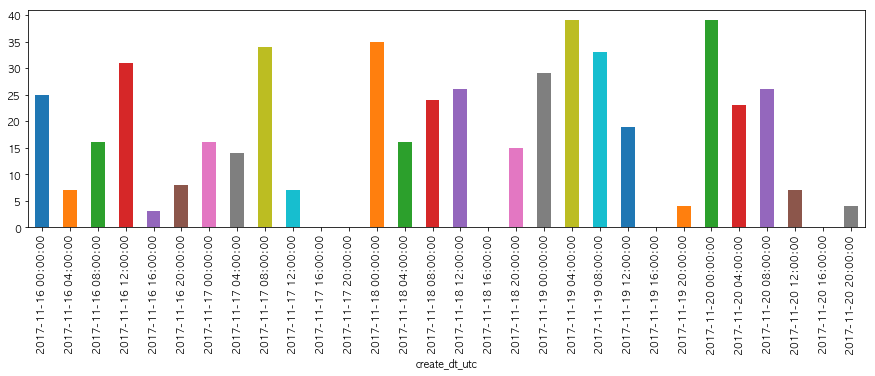

In [46]:
washer_df.groupby(grouper)['create_dt_utc'].count().plot(kind='bar', figsize=(15, 4))

새벽 시간대에 Log 기록이 왜 많은 걸까?

이상하다. 너무 새벽 시간대이다.

혹시 데이터가 이상한 건 아닌지 의심할 필요가 있을 것 같다.

그런데 지금까지 그냥 지나쳤는데 시간이 UTC로 되어있어서 그런건 아닐까?

UTC: 협정세계시

In [47]:
import datetime

kst_diff = datetime.timedelta(hours=9)

In [48]:
washer_df['create_dt_kst'] = washer_df['create_dt_utc'] + kst_diff
washer_df[['create_dt_utc', 'create_dt_kst']].head()

,create_dt_utc,create_dt_kst
0,2017-11-16 00:22:00,2017-11-16 09:22:00
1,2017-11-16 00:32:00,2017-11-16 09:32:00
2,2017-11-16 00:32:00,2017-11-16 09:32:00
3,2017-11-16 02:48:00,2017-11-16 11:48:00
4,2017-11-16 02:57:00,2017-11-16 11:57:00


한국 시각으로 변경된 데이터를 가지고 아래와 같은 그래프

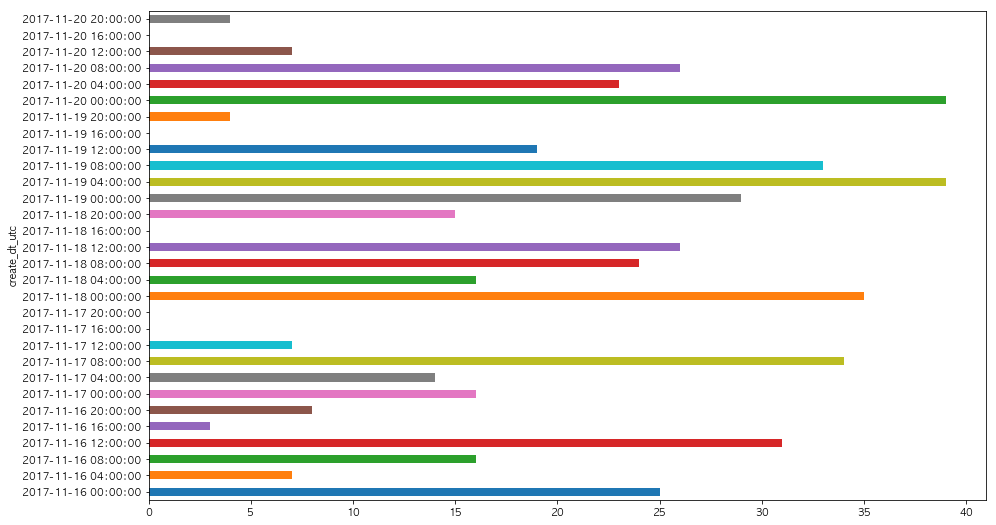

In [49]:
washer_df.groupby(grouper)['create_dt_kst'].count().plot(kind='barh', figsize=(15, 9))

<div class="alert alert-info">
세탁코스(APCourse)는 현재 숫자형태로 되어있는데 이를 범주형 데이터로 바꿔보겠습니다. (임의 데이터)
</div>

In [50]:
washer_df['APCourse'].head()

0    1
1    0
2    0
3    1
4    0
Name: APCourse, dtype: int64

In [51]:
washer_df['APCourse'].value_counts()

1     190
0     131
3      45
13     31
8      25
9      18
5      15
16     14
6      11
2       9
10      7
12      4
Name: APCourse, dtype: int64

In [52]:
ap_course_dict = {
    1: '표준세탁',
    0: '찌든때',
    3: '알뜰삶음',
    13: '스피드워시',
    8: '알러지케어',
    9: '스팀클리닝',
    5: '기능성의류',
    16: '컬러케어',
    6: '찬물세탁',
    2: '란제리/울',
    10: '이불',
    12: '헹굼/탈수',
}

In [53]:
# washer_df['APCourse'] = washer_df['APCourse'].apply(lambda course: ap_course_dict.get(course))
washer_df['APCourse'] = washer_df['APCourse'].apply(ap_course_dict.get)
washer_df['APCourse'].head()

0    표준세탁
1     찌든때
2     찌든때
3    표준세탁
4     찌든때
Name: APCourse, dtype: object

In [54]:
# catetgory type 으로 변경
washer_df['APCourse'] = washer_df['APCourse'].astype('category')
washer_df['APCourse'].head()

0    표준세탁
1     찌든때
2     찌든때
3    표준세탁
4     찌든때
Name: APCourse, dtype: category
Categories (12, object): [기능성의류, 란제리/울, 스팀클리닝, 스피드워시, ..., 찬물세탁, 컬러케어, 표준세탁, 헹굼/탈수]

<div class="alert alert-success">
Q. 각자 device 별로 세탁코스(APCourse)를 카운팅을 해보고 데이터의 이상점/특이점을 찾아보세요.
</div>

In [55]:
washer_df.groupby(['device_id', 'APCourse']).size()

device_id  APCourse
A1         기능성의류        8
           스피드워시       13
           찌든때         32
           표준세탁        51
           헹굼/탈수        4
A2         기능성의류        1
           찌든때         25
           표준세탁        70
A3         기능성의류        6
           알러지케어       25
           이불           5
           찌든때         18
           컬러케어         9
           표준세탁        41
A4         스피드워시       18
           알뜰삶음        42
           찌든때         29
           표준세탁        11
A5         란제리/울        9
           스팀클리닝       18
           알뜰삶음         3
           이불           2
           찌든때         27
           찬물세탁        11
           컬러케어         5
           표준세탁        17
dtype: int64

In [56]:
washer_df.groupby(['device_id', 'APCourse']).size().unstack().fillna(0).astype('int')

APCourse,기능성의류,란제리/울,스팀클리닝,스피드워시,알뜰삶음,알러지케어,이불,찌든때,찬물세탁,컬러케어,표준세탁,헹굼/탈수
device_id,,,,,,,,,,,,
A1,8,0,0,13,0,0,0,32,0,0,51,4
A2,1,0,0,0,0,0,0,25,0,0,70,0
A3,6,0,0,0,0,25,5,18,0,9,41,0
A4,0,0,0,18,42,0,0,29,0,0,11,0
A5,0,9,18,0,3,0,2,27,11,5,17,0


## 3/01_Titanic_for_instructor.ipynb

타이타닉호의 생존률 예측

In [57]:
train_df = pd.read_csv('LG_Python_Lecture_for_student_181010/3/data/titanic/titanic_train.csv',
                       index_col='PassengerId')
print(train_df.shape)
train_df.head()

(891, 11)


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [58]:
test_df = pd.read_csv('LG_Python_Lecture_for_student_181010/3/data/titanic/titanic_test.csv',
                      index_col='PassengerId')
print(test_df.shape)
test_df.head()

(418, 10)


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [59]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [60]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
Pclass      418 non-null int64
Name        418 non-null object
Sex         418 non-null object
Age         332 non-null float64
SibSp       418 non-null int64
Parch       418 non-null int64
Ticket      418 non-null object
Fare        417 non-null float64
Cabin       91 non-null object
Embarked    418 non-null object
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


케글 타이타닉 페이지에서 각 필드 정보를 살펴봅시다.

### 변수 간 상관관계는 어느 정도일까?

상관계수(Correlation Coefficient)

+ 두 변수간에 어떤 선형적 관계를 갖고 있는 지를 분석하는 방법이다.
+ 두 변수는 서로 독립적인 관계로부터 서로 상관된 관계일 수 있으며 이때 두 변수간의 관계의 강도를 상관관계(Correlation, Correlation coefficient)라 한다.

In [61]:
names = ["Survived", "Pclass", "SibSp", "Parch", "Age", "Fare"]
train_df[names].corr()

,Survived,Pclass,SibSp,Parch,Age,Fare
Survived,1.000000,-0.338481,-0.035322,0.081629,-0.077221,0.257307
Pclass,-0.338481,1.000000,0.083081,0.018443,-0.369226,-0.549500
SibSp,-0.035322,0.083081,1.000000,0.414838,-0.308247,0.159651
Parch,0.081629,0.018443,0.414838,1.000000,-0.189119,0.216225
Age,-0.077221,-0.369226,-0.308247,-0.189119,1.000000,0.096067
Fare,0.257307,-0.549500,0.159651,0.216225,0.096067,1.000000


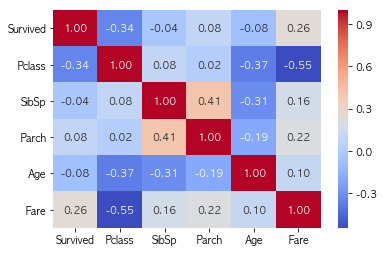

In [62]:
import seaborn as sns

sns.heatmap(
    train_df[["Survived", "Pclass", "SibSp", "Parch", "Age", "Fare"]].corr(),  # value
    annot=True,  # 주석 (annotation)
    fmt=".2f",  # format (f: float)
    cmap="coolwarm"  # color
);

In [63]:
# S: Southampton
# C: Cherbourg
# Q: Queenstown
train_df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

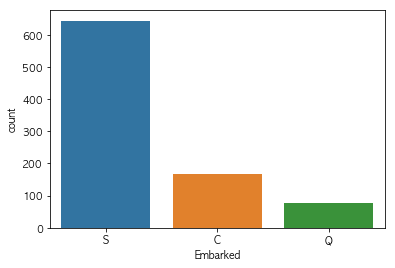

In [64]:
sns.countplot('Embarked', data=train_df);

Text(0,0.5,'count')

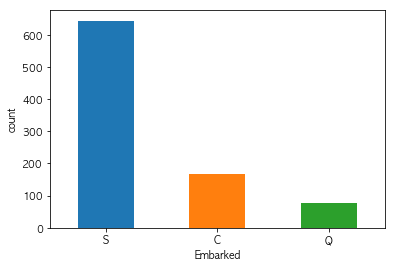

In [65]:
ax = train_df['Embarked'].value_counts().plot(kind='bar', rot=0)
ax.set_xlabel('Embarked')
ax.set_ylabel('count')

<div class="alert alert-warning">
Embarked 컬럼의 결측치를 채워보자.
</div>

In [66]:
train_df.isnull().any()

Survived    False
Pclass      False
Name        False
Sex         False
Age          True
SibSp       False
Parch       False
Ticket      False
Fare        False
Cabin        True
Embarked     True
dtype: bool

In [67]:
# Emarked의 결측치를 무엇으로 채우면 좋을까요?
train_df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [68]:
train_df['Embarked'].value_counts() / train_df.shape[0] * 100

S    72.278339
C    18.855219
Q     8.641975
Name: Embarked, dtype: float64

In [69]:
train_df['Embarked'] = train_df['Embarked'].fillna('S')

In [70]:
train_df['Embarked'].isnull().any()

False

https://seaborn.pydata.org/generated/seaborn.countplot.html

우리의 목표인 생존율(Survived)과 Embarked를 함께 비교해볼 때 hue라는 파라미터를 이용하면 쉽게 비교가 가능합니다.

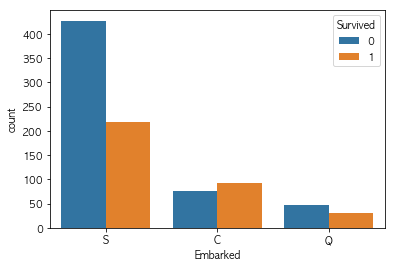

In [71]:
sns.countplot('Embarked', hue='Survived', data=train_df)

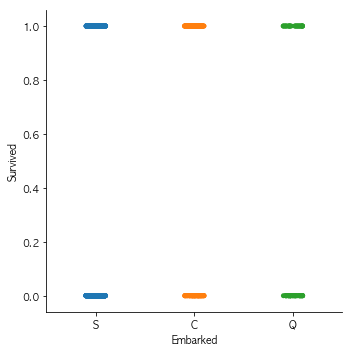

In [72]:
sns.catplot('Embarked', 'Survived', data=train_df);

<div class="alert alert-warning">
Age 컬럼의 결측치를 채워보자.
</div>

In [73]:
train_df['Age'].isnull().sum()

177

In [74]:
train_df['Age'].isnull().sum() / len(train_df['Age']) * 100

19.865319865319865

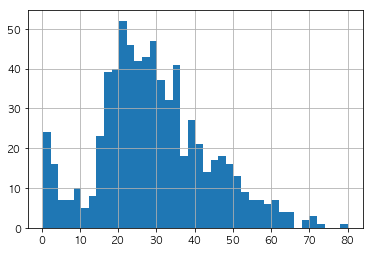

In [75]:
train_df['Age'].hist(bins=40);

여러가지 컬럼값을 하나의 그래프로 나타내는 방법들도 존재한다!

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


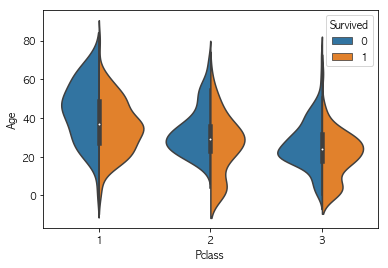

In [76]:
sns.violinplot('Pclass', 
               'Age', 
               hue='Survived', 
               data=train_df, 
               split=True)

<div class="alert alert-info">
다양한 시각화 방법이 존재한다.
</div>

In [77]:
# Confusion matrix : https://pandas.pydata.org/pandas-docs/stable/generated/pandas.crosstab.html
pd.crosstab(train_df['Pclass'], train_df['Survived'], margins=True)

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


Text(0.5,1,'Pclass:Survived vs Dead')

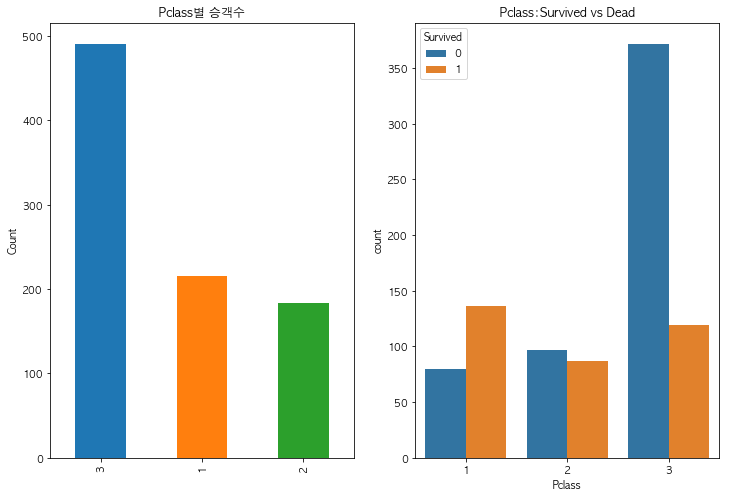

In [78]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

# 0
train_df['Pclass'].value_counts().plot(kind='bar', ax=ax[0])
ax[0].set_title('Pclass별 승객수')
ax[0].set_ylabel('Count')

# 1
sns.countplot('Pclass', hue='Survived', data=train_df, ax=ax[1])
ax[1].set_title('Pclass:Survived vs Dead')

<div class="alert alert-info">
Q: 탑승항('Embarked')을 기준으로 승객을 분류하여, 각각의 승객의 나이에 따른 생존 여부를 violinplot 그래프를 이용해서 표현해보자.

탑승항에 따른 생존율의 차이가 나타나는가?

=> Exp(탐험적) Data Analysis
</div>

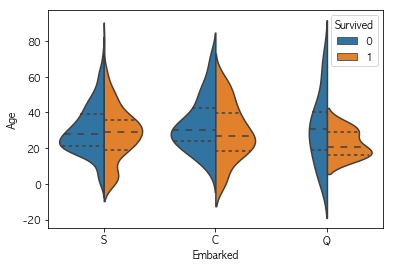

In [79]:
sns.violinplot(
    'Embarked',
    'Age', 
    hue='Survived', 
    data=train_df, 
    split=True, 
    inner="quartile");  # 25%, 50%, 75%

<div class="alert alert-info">
Q: 성별('Sex')을 기준으로 승객을 분류하여 각각의 승객의 나이에 따른 생존 여부를 그래프로 표현해보자.

성별에 따른 생존율의 차이가 나타나는가?
</div>

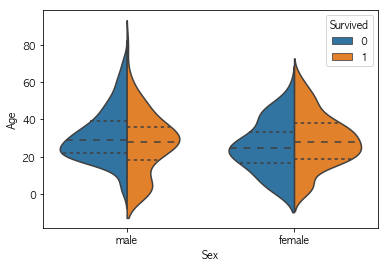

In [80]:
sns.violinplot(
    'Sex', 
    'Age', 
    hue='Survived', data=train_df, split=True, inner="quartile");

<div class="alert alert-info">
Q. 성별('Sex')에 따른 승객의 생존자 수를 crosstab으로 표현해보자. 성별에 따른 생존율의 차이가 나타나는가?
</div>

In [81]:
pd.crosstab(train_df['Sex'], train_df['Survived'], margins=True)

Survived,0,1,All
Sex,,,
female,81,233,314
male,468,109,577
All,549,342,891


<div class="alert alert-info">
Q. Age의 결측치를 어떻게 채우는 것이 좋을까? 주어진 데이터를 활용하여 결측치를 채우는 방법을 토론해보자.
</div>

In [82]:
# 평균?
train_df['Age'].mean()

29.69911764705882

In [83]:
# 중앙값?
train_df['Age'].median()

28.0

In [84]:
# 최빈값? (가장 자주 나오는 값)
train_df['Age'].mode()

0    24.0
dtype: float64

성별 class별 나이의 중앙값으로 채워서 최대한 데이터의 왜곡이 없도록 하겠습니다!

<div class="alert alert-info">
성별에 따른 나이차는 없을까?
</div>

In [85]:
mask = train_df['Sex'] == 'male'
train_df.loc[mask, 'Age'].mean()

30.72664459161148

In [86]:
mask = train_df['Sex'] == 'female'
train_df.loc[mask, 'Age'].mean()

27.915708812260537

<div class="alert alert-info">
Q. 승객의 성별('Sex') 나이의 중앙값을 찾아보자.
</div>

In [87]:
mask = train_df['Sex'] == 'male'
train_df.loc[mask, 'Age'].median()

29.0

In [88]:
mask = train_df['Sex'] == 'female'
train_df.loc[mask, 'Age'].median()

27.0

<div class="alert alert-info">
Q. 승객의 선실 등급('Pclass')별 나이의 중앙값을 찾아보자.
</div>

In [89]:
train_df['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [90]:
mask = train_df['Pclass'] == 1
train_df.loc[mask, 'Age'].median()

37.0

In [91]:
mask = train_df['Pclass'] == 2
train_df.loc[mask, 'Age'].median()

29.0

In [92]:
mask = train_df['Pclass'] == 3
train_df.loc[mask, 'Age'].median()

24.0

In [93]:
train_df.groupby('Pclass')['Age'].agg('median')

Pclass
1    37.0
2    29.0
3    24.0
Name: Age, dtype: float64

<div class="alert alert-info">
Q. 승객의 선실 등급('Pclass')과 성별('Sex)을 둘다 고려하여 분류하고 각각의 나이의 중앙값을 찾아보자. (1등석에 탑승한 여자의 나이의 Median은? 2등석에 탑승한 남자의 나이의 Median은?)
</div>

In [94]:
mask = (train_df['Sex'] == 'male') & (train_df['Pclass'] == 1)
train_df.loc[mask, 'Age'].median()

40.0

In [95]:
age_median_series = train_df.groupby(['Sex', 'Pclass'])['Age'].median()
age_median_series

Sex     Pclass
female  1         35.0
        2         28.0
        3         21.5
male    1         40.0
        2         30.0
        3         25.0
Name: Age, dtype: float64

<div class="alert alert-info">
이 자료를 이용하여 Age의 결측치를 채워보자.
</div>

In [96]:
train_df['Age'].isnull().sum()  # null -> True 개수

177

In [97]:
sex_list = train_df['Sex'].unique()
pclass_list = train_df['Pclass'].unique()

for (sex, pclass) in [(sex, pclass) for pclass in pclass_list for sex in sex_list]:
    print(sex, pclass)
    mask = train_df['Age'].isnull()
    mask &= train_df['Sex'] == sex
    mask &= train_df['Pclass'] == pclass

    median = age_median_series[sex][pclass]
    
    train_df.loc[mask, 'Age'] = median

male 3
female 3
male 1
female 1
male 2
female 2


In [98]:
train_df['Age'].isnull().sum()  # null -> True 개수

0

<div class="alert alert-info">
Q. 같은 방식으로 나머지 결측치도 채워보자.
</div>

<div class="alert alert-info">
Cabin의 결측치를 채우는 방법은 무엇이 있을까?
</div>

In [99]:
train_df['Cabin'].describe()

count     204
unique    147
top        G6
freq        4
Name: Cabin, dtype: object

In [100]:
train_df['Cabin'].sample(30)

PassengerId
851     NaN
537     B38
2       C85
576     NaN
253     C87
845     NaN
554     NaN
512     NaN
95      NaN
673     NaN
319      C7
841     NaN
413     C78
454     C92
610    C125
800     NaN
123     NaN
18      NaN
296     NaN
516     D46
601     NaN
567     NaN
649     NaN
650     NaN
106     NaN
848     NaN
210     A31
878     NaN
542     NaN
400     NaN
Name: Cabin, dtype: object

In [101]:
train_df.shape

(891, 11)

<div class="alert alert-warning">
Cabin 컬럼을 채우는 것이 의미가 있을까? 채워지는 데이터는 신뢰할 수 있는걸까?
</div>

<div class="alert alert-warning">
Cabin 컬럼을 데이터 프레임에서 제거해보자.
</div>

<div class="alert alert-warning">
생존에 예측에 도움이 되지 않는 다른 컬럼들도 제거해 보자.
</div>

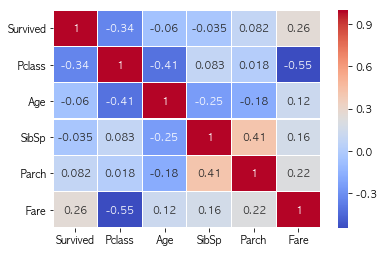

In [102]:
sns.heatmap(
    train_df.corr(), 
    annot=True,
    cmap='coolwarm',
    linewidths=0.2
);

In [103]:
train_df['Name'].sample(20)

PassengerId
306                       Allison, Master. Hudson Trevor
44              Laroche, Miss. Simonne Marie Anne Andree
747                          Abbott, Mr. Rossmore Edward
814                   Andersson, Miss. Ebba Iris Alfrida
413                               Minahan, Miss. Daisy E
690                    Madill, Miss. Georgette Alexandra
610                            Shutes, Miss. Elizabeth W
471                                    Keefe, Mr. Arthur
486                               Lefebre, Miss. Jeannie
518                                    Ryan, Mr. Patrick
630                             O'Connell, Mr. Patrick D
386                            Davies, Mr. Charles Henry
14                           Andersson, Mr. Anders Johan
834                               Augustsson, Mr. Albert
401                                   Niskanen, Mr. Juha
455                                  Peduzzi, Mr. Joseph
395    Sandstrom, Mrs. Hjalmar (Agnes Charlotta Bengt...
382                

<div class="alert alert-warning">
Q. Name 컬럼의 정보들이 정말 예측에 도움이 되지 않을까?
</div>

In [104]:
# train_df = train_df.drop(['PassengerId', 'Name', 'Ticket'], axis=1)

<div class="alert alert-info">
기존 데이터 셋의 정보를 이용하여 새로운 컬럼을 추가해보자(Feature Engineering!)
</div>

In [105]:
train_df['Fsize'] = train_df['SibSp'] + train_df['Parch'] + 1
train_df[['SibSp', 'Parch', 'Fsize']].head()

,SibSp,Parch,Fsize
PassengerId,,,
1,1,0,2
2,1,0,2
3,0,0,1
4,1,0,2
5,0,0,1


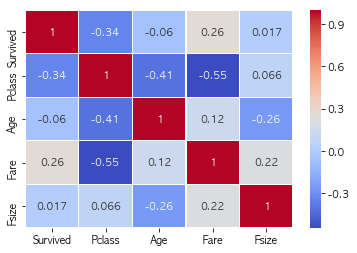

In [106]:
names = ['Survived', 'Pclass', 'Age', 'Fare', 'Fsize']

sns.heatmap(train_df[names].corr(), annot=True, cmap='coolwarm', linewidths=0.2);

<div class="alert alert-info">
기계학습을 위해 문자열을 숫자로 치환하여 보자.
</div>

One Hot Encoding

In [107]:
train_df['Sex'] = train_df['Sex'].replace(['male','female'], [0, 1])
train_df['Embarked'] = train_df['Embarked'].replace(['S','C','Q'], [0, 1, 2])

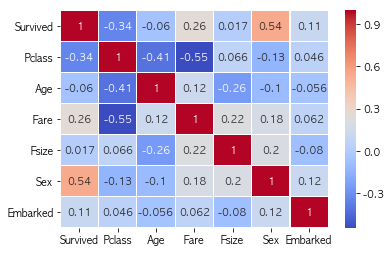

In [108]:
names = ['Survived', 'Pclass', 'Age', 'Fare', 'Fsize', 'Sex', 'Embarked']

sns.heatmap(train_df[names].corr(), annot=True, cmap='coolwarm', linewidths=0.2);

<div class="alert alert-info">
전처리한 데이터를 가지고 기계학습을 통해 생존 여부를 예측해보자
</div>

In [109]:
names = ['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Fsize']
train_df = train_df[names]

In [110]:
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn import svm  # support vector Machine
from sklearn.ensemble import RandomForestClassifier # Random Forest
from sklearn.tree import DecisionTreeClassifier # Decision Tree
from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [111]:
train, test = train_test_split(
    train_df, test_size=0.3, random_state=2, stratify=train_df['Survived'])

train_X = train[train.columns[1:]]
train_Y = train[train.columns[:1]]

test_X = test[test.columns[1:]]
test_Y = test[test.columns[:1]]

X = train_df[train_df.columns[1:]]
Y = train_df['Survived']

In [112]:
model = LogisticRegression()
model.fit(train_X, train_Y)
prediction1 = model.predict(test_X)
print('The accuracy of the Logistic Regression is', 
      metrics.accuracy_score(prediction1, test_Y))

The accuracy of the Logistic Regression is 0.7985074626865671


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [113]:
model = svm.SVC(kernel='linear', C=0.1, gamma=0.1)
model.fit(train_X,train_Y)
prediction2 = model.predict(test_X)
print('Accuracy for linear SVM is', metrics.accuracy_score(prediction2, test_Y))

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy for linear SVM is 0.7723880597014925


In [114]:
model = DecisionTreeClassifier()
model.fit(train_X, train_Y)
prediction3 = model.predict(test_X)
print('The accuracy of the Decision Tree is', metrics.accuracy_score(prediction3, test_Y))

The accuracy of the Decision Tree is 0.7611940298507462


In [115]:
train_X.columns

Index(['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Fsize'], dtype='object')

In [116]:
model = RandomForestClassifier(n_estimators=340)
model.fit(train_X,train_Y)

prediction4 = model.predict(test_X)
print('The accuracy of the Random Forests is', metrics.accuracy_score(prediction4, test_Y))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


The accuracy of the Random Forests is 0.8134328358208955


In [117]:
model.feature_importances_

array([0.08128129, 0.26812729, 0.26313307, 0.27343622, 0.03372522,
       0.08029691])

하이퍼 파라미터 튜닝(매개변수 최적화)을 통해 모델의 성능을 향상시켜보자.

In [118]:
from sklearn.model_selection import GridSearchCV

In [119]:
n_estimators = range(10, 500, 10)
hyperparam = {'n_estimators': n_estimators}
gd = GridSearchCV(estimator=RandomForestClassifier(random_state=2), param_grid=hyperparam, verbose=True)
gd.fit(X,Y)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 3 folds for each of 49 candidates, totalling 147 fits


[Parallel(n_jobs=1)]: Done 147 out of 147 | elapsed:   46.6s finished


0.8069584736251403
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=340, n_jobs=1,
            oob_score=False, random_state=2, verbose=0, warm_start=False)
